<a href="https://colab.research.google.com/github/BrandonKTC/Statistic_python/blob/main/Google_Causal_Impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librairies and Dates

In [16]:
# Install librairies
!pip install yfinance
!pip install tfcausalimpact

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
# Import librairies
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Define Dates
training_start = "2020-09-01"
training_end = "2020-10-19"
treatment_start = "2020-10-20"
treatment_end = "2020-10-23"
end_stock = "2020-10-24"

# Loading financial Data

In [19]:
# Bitcoin Data
y = ["BTC-USD"]
y = yf.download(tickers=y,
                start=training_start,
                end=end_stock,
                interval="1d")
y = y["Adj Close"].rename("y")
y[:1]

[*********************100%***********************]  1 of 1 completed


Date
2020-09-01    11970.478516
Name: y, dtype: float64

In [20]:
# Load more data
stocks = ["CARL-B.CO", "ZAL.DE", "SQ", "CRSP", "TRMB", "JD", "DE", "KTOS", "GOOG"]
X = yf.download(tickers=stocks,
                start=training_start,
                end=end_stock,
                interval="1d")
X.head()

[*********************100%***********************]  9 of 9 completed


Adj Close                         ...      Volume                   
             CARL-B.CO       CRSP          DE  ...          SQ       TRMB  ZAL.DE
Date                                           ...                               
2020-09-01  816.406250  93.419998  212.624512  ...  12306400.0   542300.0  790198
2020-09-02  824.950073  93.930000  212.057983  ...  11214800.0   728800.0  496554
2020-09-03  840.708557  85.690002  205.904572  ...  16421200.0  1220300.0  736259
2020-09-04  826.848694  82.019997  206.422272  ...  17995200.0   914700.0  662250
2020-09-07  835.392456        NaN         NaN  ...         NaN        NaN  362062

[5 rows x 54 columns]

In [21]:
# Getting just the adjusted close
X = X.iloc[:,:len(stocks)]
#Removing unneded level
X.columns=X.columns.droplevel()
X.head()

,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-01,816.406250,93.419998,212.624512,83.035500,80.459969,19.700001,166.660004,53.410000,77.000000
2020-09-02,824.950073,93.930000,212.057983,86.414001,81.162254,19.910000,162.880005,54.310001,77.000000
2020-09-03,840.708557,85.690002,205.904572,82.092003,77.094872,19.520000,152.860001,50.900002,75.080002
2020-09-04,826.848694,82.019997,206.422272,79.552002,78.031250,19.260000,146.389999,49.959999,71.739998
2020-09-07,835.392456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000


In [22]:
#Combine everything
df = pd.concat([y, X], axis=1).dropna()
df.head()

,y,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2020-09-01,11970.478516,816.406250,93.419998,212.624512,83.035500,80.459969,19.700001,166.660004,53.410000,77.000000
2020-09-02,11414.034180,824.950073,93.930000,212.057983,86.414001,81.162254,19.910000,162.880005,54.310001,77.000000
2020-09-03,10245.296875,840.708557,85.690002,205.904572,82.092003,77.094872,19.520000,152.860001,50.900002,75.080002
2020-09-04,10511.813477,826.848694,82.019997,206.422272,79.552002,78.031250,19.260000,146.389999,49.959999,71.739998
2020-09-08,10131.516602,821.532532,81.459999,205.347885,76.619499,74.344276,19.230000,139.110001,49.139999,73.440002


# Data Analysis

In [23]:
# Prepare Dataframe with only Training Data
df_training = df[df.index <= training_end]
df_training.tail()

,y,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2020-10-13,11425.899414,850.771301,103.059998,232.496353,78.584000,80.577019,20.959999,190.470001,51.720001,85.820000
2020-10-14,11429.506836,845.455139,101.370003,233.721451,78.403999,79.104179,21.010000,187.490005,50.540001,84.980003
2020-10-15,11495.349609,830.835815,99.889999,233.496048,77.956497,78.275093,21.100000,188.600006,52.290001,84.419998
2020-10-16,11322.123047,823.810852,109.830002,235.279785,78.650497,79.513840,20.790001,186.350006,52.340000,84.800003
2020-10-19,11742.037109,826.658813,107.720001,233.427399,76.730499,78.626236,20.639999,186.960007,51.970001,85.000000


In [27]:
# Stationarity
from statsmodels.tsa.stattools import adfuller

p_value = adfuller(x=df_training.y)[1]
print(p_value)
if p_value < 0.05:
  print("The time series is stationary")
else:
  print("The Time Series is not stationary")

0.09874703208822727
The Time Series is not stationary


In [31]:
# differencing
differencing = df_training.pct_change().dropna()

In [34]:
# Adfuller on differenced data
from statsmodels.tsa.stattools import adfuller

p_value = adfuller(x=differencing.y)[1]
print(p_value)
if p_value < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

3.8054323617260893e-07
The Time Series is stationary


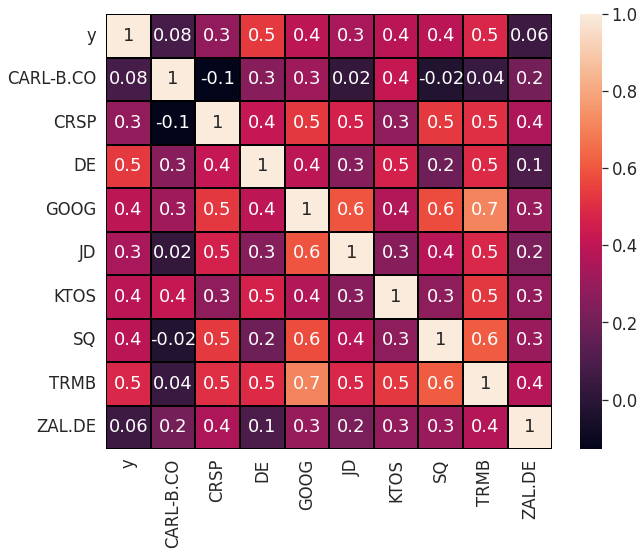

In [37]:
# Correlation matrix
plt.figure(figsize=(10,8))
sns.set(font_scale=1.5)
sns.heatmap(differencing.corr(),
            annot=True,
            fmt=".1g",
            linewidth=1,
            linecolor='black')

#google Causal Impact

In [40]:
# Prepare the dataset
df_final = df.drop(["CARL-B.CO","ZAL.DE"], axis=1)
df_final.head(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB
Date,,,,,,,,
2020-09-01,11970.478516,93.419998,212.624512,83.0355,80.459969,19.700001,166.660004,53.41


In [42]:
# Prepare pre and post period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

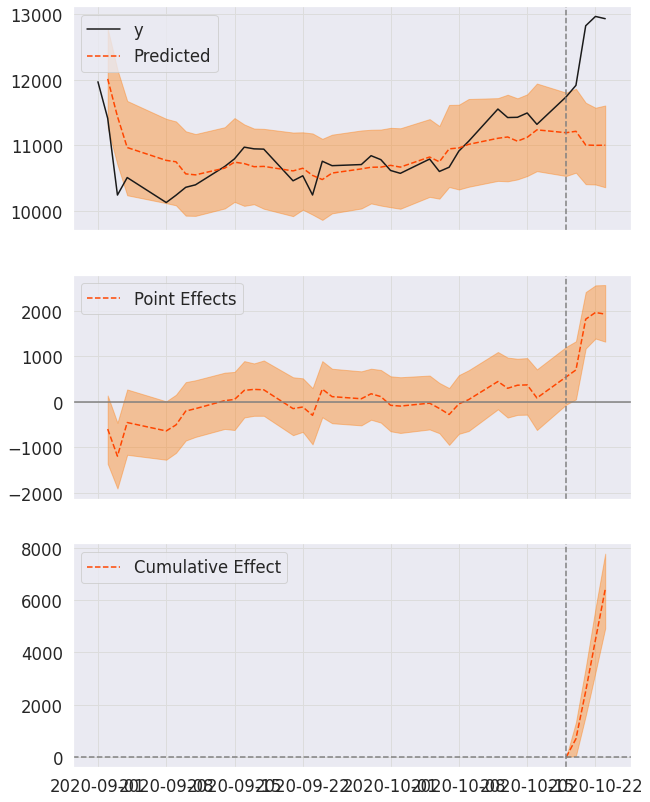

In [47]:
# Google Causal Impact
impact = CausalImpact(data=df_final,
                      pre_period=pre_period,
                      post_period=post_period)
impact.plot(figsize=(10,14));

In [49]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         11057.63 (177.47)  44230.5 (709.89)
95% CI                    [10722.83, 11418.51][42891.32, 45674.03]

Absolute effect (s.d.)    1601.74 (177.47)   6406.95 (709.89)
95% CI                    [1240.86, 1936.53] [4963.42, 7746.13]

Relative effect (s.d.)    14.49% (1.6%)      14.49% (1.6%)
95% CI                    [11.22%, 17.51%]   [11.22%, 17.51%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [50]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 11057.63.
The 95% interval of this counterfactual prediction is [10722.83, 11418.51].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1601.74 with a 95% interval of
[1240.86, 1936.53]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 44230.5. The 95% interval of this prediction is [42891.32, 45674.03].


The above results are given in terms of absolute numbers. In relative
t